#### Import Libs

In [5]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os
import time
import datetime
#from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')


/workspace/ai_intern/anaconda3/envs/kyky/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/ai_intern/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Import datasets & Read data

In [6]:
# Đọc file .txt
file_path = '/workspace/ai_intern/Lucky/Writing IELTS_Task2/writing_task_2.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

# In ra nội dung file (in một phần để tránh quá dài)
print(text[:3500])  # In 3500 ký tự đầu tiên


Poverty represents a worldwide crisis. It is the ugliest epidemic in a region, which could infect countries in the most debilitating ways. To tackle this issue, rich countries need to help those in need and give a hand when possible. I agree that there are several ways of aiding poor countries other than financial aid, like providing countries in need with engineers, workers, and soldiers who would build infrastructure. Building universities, hospitals, and roadways. By having a solid infrastructure, poor countries would be able to monetise their profits and build a stronger and more profitable economy which would help them in the long term. Once unprivilged countries find their niche, the major hurdle would be passed and would definitely pave the way for much brighter future. However, I do disagree that financial aid does not solve poverty, it does if used properly and efficiently. The most determining factor if financial aid would be the way to go, is by identifying what type of poor

#### Data Preprocessing

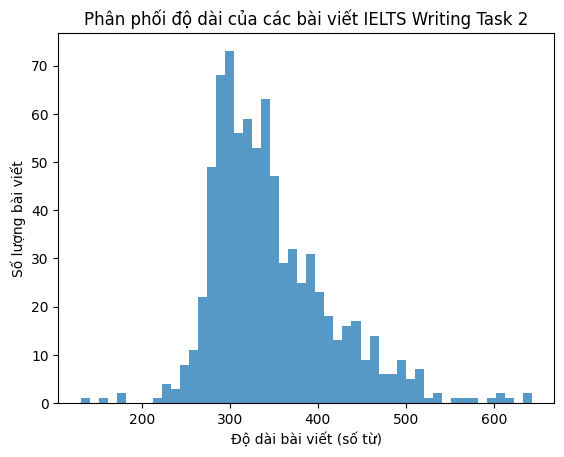

Độ dài trung bình của các bài viết: 346.5081967213115


In [7]:
# Tách các bài viết dựa trên delimiter "---"
essays = text.split("\n\n---\n\n")

# Tokenize các bài viết
tokenized_essays = [nltk.word_tokenize(essay) for essay in essays]

# Tính toán độ dài của các bài viết
doc_lengths = [len(essay) for essay in tokenized_essays]

# Vẽ biểu đồ độ dài của các bài viết
plt.hist(doc_lengths, bins=50, alpha=0.75)
plt.xlabel('Độ dài bài viết (số từ)')
plt.ylabel('Số lượng bài viết')
plt.title('Phân phối độ dài của các bài viết IELTS Writing Task 2')
plt.show()

# Tính toán độ dài trung bình của các bài viết
average_length = sum(doc_lengths) / len(doc_lengths)
print(f'Độ dài trung bình của các bài viết: {average_length}')


In [8]:
print(len(doc_lengths))

793


In [9]:
# Lọc các bài viết rỗng 
filtered_essays = [essay for essay in essays if len(essay.strip()) > 0]

In [10]:
print(len(doc_lengths))

793


In [11]:
max_gpt2_tokens = 768
if average_length <= max_gpt2_tokens:
    print("Độ dài trung bình của các bài viết phù hợp với giới hạn tối đa của GPT-2.")
else:
    print("Độ dài trung bình của các bài viết vượt quá giới hạn tối đa của GPT-2.")


Độ dài trung bình của các bài viết phù hợp với giới hạn tối đa của GPT-2.


In [12]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f'bos_token: {tokenizer.bos_token}, eos_token: {tokenizer.eos_token}')

bos_token: <|startoftext|>, eos_token: <|endoftext|>


In [14]:
class GPT2Dataset(Dataset):

    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:
            if len(txt.strip()) > 0: 
                encodings_dict = tokenizer(
                    txt, 
                    truncation=True, 
                    max_length=max_length, 
                    padding="max_length"
                )

                self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
                self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]


In [15]:
# Tạo dataset từ danh sách các văn bản đã lọc
dataset = GPT2Dataset(filtered_essays, tokenizer, max_length=768)

# Chia tập huấn luyện và kiểm tra
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  713 training samples
   80 validation samples


In [16]:
# Đặt kích thước batch
batch_size = 2

In [17]:
# Tạo DataLoader cho các tập huấn luyện và kiểm tra
train_dataloader = DataLoader(
    train_dataset,  
    sampler=RandomSampler(train_dataset),  
    batch_size=batch_size
)

validation_dataloader = DataLoader(
    val_dataset,  
    sampler=SequentialSampler(val_dataset), 
    batch_size=batch_size  
)

# Kiểm tra dữ liệu từ train_dataloader và validation_dataloader
for batch in train_dataloader:
    input_ids, attn_masks = batch
    print("Training batch input_ids:", input_ids)
    print("Training batch attention_masks:", attn_masks)
    break

for batch in validation_dataloader:
    input_ids, attn_masks = batch
    print("Validation batch input_ids:", input_ids)
    print("Validation batch attention_masks:", attn_masks)
    break

Training batch input_ids: tensor([[  464,  5798,   329,  ..., 50258, 50258, 50258],
        [ 4366,   661,  1975,  ..., 50258, 50258, 50258]])
Training batch attention_masks: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Validation batch input_ids: tensor([[ 1026,   318,  4762,  ..., 50258, 50258, 50258],
        [ 3844, 20544,    11,  ..., 50258, 50258, 50258]])
Validation batch attention_masks: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


#### Setting up for FineTune

In [18]:
# Đặt config của model
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Khởi tạo model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# Điều chỉnh kích thước embedding của mô hình để phù hợp với tokenizer
model.resize_token_embeddings(len(tokenizer))

# Thiết lập thiết bị để sử dụng GPU 
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

# Đặt giá trị seed 
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [19]:
# Parameters for training
epochs = 2
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 100

In [20]:
# Khởi tạo optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)

/workspace/ai_intern/anaconda3/envs/kyky/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### FineTune GPT2 for IELTS Writing Task 2

In [21]:
# Tổng số bước training
total_steps = len(train_dataloader) * epochs

# Khởi tạo scheduler để điều chỉnh learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks, token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # In ra sample output mỗi 100 bước
        if step % sample_every == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50, 
                                    max_length=200,
                                    top_p=0.95,
                                    num_return_sequences=1,
                                    pad_token_id=tokenizer.eos_token_id
                                )
            for i, sample_output in enumerate(sample_outputs):
                print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_masks, labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


  Batch   100  of    357. Loss: 1.7621362209320068.   Elapsed: 0:00:34.
0:  bipartisan and politically correct.

If I have a long and long stay for such and such and such and such I will see them live on, I will not see them live on, but I will have a long stay after a long stay. If I have a long and long stay, I will see them live on, but I will not be able to see them live on, especially if I have an emergency, so I will have to leave them.

If I leave a long stay on an emergency, then I will see them live on, but I will not be able to see them live on, particularly if I have an emergency. I will see them live on, but I will not be able to see them live on, especially if my emergency condition affects my family as well as the children.

If I leave some other reason, then I will see them live on, but I will not be able to see them live on, because my family members can't
  Batch   200  of    357. Loss: 1.9244252443313599.   Elapsed: 0:00:53.
0:  increasing the use of technology to com

#### Summarize training process

       Training Loss  Valid. Loss Training Time Validation Time
epoch                                                          
1           3.060274     1.648275       0:01:20         0:00:02
2           1.549128     1.621119       0:00:59         0:00:02


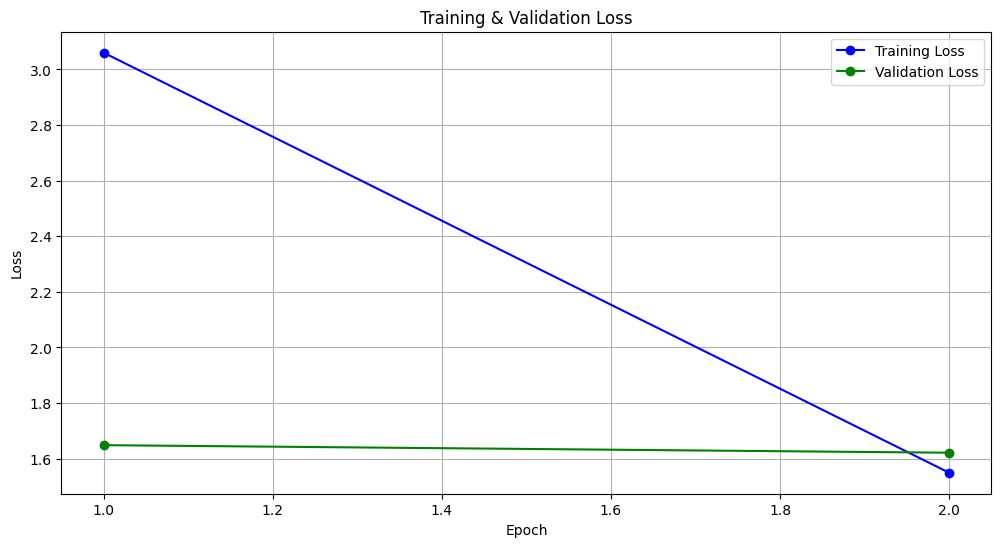

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy chữ số thập phân là hai chữ số.
pd.options.display.float_format = '{:.6f}'.format

# Tạo DataFrame từ danh sách các thống kê huấn luyện.
df_stats = pd.DataFrame(data=training_stats)

# Sử dụng 'epoch' làm chỉ số hàng.
df_stats = df_stats.set_index('epoch')

print(df_stats)

plt.figure(figsize=(12, 6))
plt.plot(df_stats['Training Loss'], 'b-o', label='Training Loss')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



In [23]:
# Khởi tạo mô hình
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [24]:
import os
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Đặt đường dẫn để lưu mô hình
output_dir = './model_save/'

# Tạo thư mục nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Lưu mô hình đã được huấn luyện, cấu hình và tokenizer sử dụng `save_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Lưu các đối số huấn luyện cùng với mô hình đã được huấn luyện (tùy chọn)
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

#### Generate IELTS writing task2

In [3]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import os

output_dir = './model_save/'

print("Loading model from %s" % output_dir)

# Tải lại mô hình đã được lưu
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hàm để sinh ra văn bản
def generate_essay(prompt, model, tokenizer, max_length=200, num_return_sequences=1):
    model.eval()
    
    # Tokenize đầu vào
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    
    # Sinh ra văn bản
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            no_repeat_ngram_size=2,
            top_k=50,
            top_p=0.95,
            temperature=1.0,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    
    essays = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return essays

# Hàm định dạng văn bản cho dễ đọc
def format_essay(essay, max_sentence_length=80):
    words = essay.split()
    formatted_essay = []
    current_paragraph = []
    current_length = 0

    for word in words:
        current_length += len(word) + 1
        current_paragraph.append(word)
        
        if '.' in word and current_length >= max_sentence_length:
            formatted_essay.append(' '.join(current_paragraph))
            current_paragraph = []
            current_length = 0
    
    if current_paragraph:
        formatted_essay.append(' '.join(current_paragraph))
    
    return '\n\n'.join(formatted_essay)

# Ví dụ prompt để sinh ra bài viết IELTS
prompt = "In recent years, the impact of technology on society has been a topic of debate. Discuss the advantages and disadvantages of technology in modern life."

essays = generate_essay(prompt, model, tokenizer, max_length=300, num_return_sequences=2)

for i, essay in enumerate(essays):
    formatted_essay = format_essay(essay)
    print(f"Essay {i + 1}:\n{formatted_essay}\n")

# Lưu kết quả vào file
output_file = "generated_essays.txt"
with open(output_file, 'w', encoding='utf-8') as f:
    for i, essay in enumerate(essays):
        formatted_essay = format_essay(essay)
        f.write(f"Essay {i + 1}:\n{formatted_essay}\n\n")
print(f"Generated essays have been saved to {output_file}")




Loading model from ./model_save/


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Essay 1:
In recent years, the impact of technology on society has been a topic of debate.

Discuss the advantages and disadvantages of technology in modern life. In recent months, there has also been an increasing number of studies that highlight the effects of technological change on the health of persons and families.

But the debate about whether technological advancement brings about the best outcomes remains not without serious problems.

In the first five years of the millennium, we recorded a decline in mortality among men and the decrease in death and disability among women from mortality rates over 1 year.

This trend is reflected in the observed change in birth rates (19%) and in rates of disability (11%) compared with the same period in 1996.

The data suggest that the number and quality of care provided by health facilities are significantly lower during the time of economic changes such as health inflation, social unrest and rising rates for women.

One important finding, 